<a href="https://colab.research.google.com/github/salihdegrli/churn_analysis/blob/main/churn_analysis_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install catboost

In [2]:
!pip install scikit-learn==1.1.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.0/32.0 MB 34.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.34.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.1.3 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.1.3 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.1.3 which is incompatible.


In [3]:
!pip show scikit-learn

Name: scikit-learn
Version: 1.1.3
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /usr/local/lib/python3.11/dist-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: bigframes, fastai, imbalanced-learn, librosa, mlxtend, sentence-transformers, shap, sklearn-compat, sklearn-pandas, yellowbrick


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import eda
import data_prep
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import joblib
import warnings
warnings.simplefilter(action='ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


##Load Data

In [87]:
df = pd.read_csv("churn_train.csv")

In [88]:
#datasetin tamamı 2013 yılına ait olduğu için yıl değişkeni kaldırıldı.
df.drop("year", axis=1, inplace=True)
#user_account_id her kişi için unique olduğu için datasetten kaldırıldı.
df.drop("user_account_id", axis=1, inplace=True)
# user_lifetime'ı 0 olanlar üzerinden bir analiz yapılamayacağı için datasetten kaldırıldı.
df.drop((df.user_lifetime[df.user_lifetime == 0].index), axis=0, inplace=True)

##EDA

In [74]:
cat_cols, num_cols, cat_but_car = eda.grab_col_names(df)

Observations: 59971
Variables: 64
cat_cols: 7
num_cols: 57
cat_but_car: 0
num_but_cat: 7


In [75]:
cat_cols

['month',
 'user_intake',
 'user_has_outgoing_calls',
 'user_has_outgoing_sms',
 'user_use_gprs',
 'user_does_reload',
 'churn']

In [76]:
eda.check_df(df)

##################### Shape #####################
(59971, 64)
##################### Types #####################
month                                      int64
user_lifetime                              int64
user_intake                                int64
user_no_outgoing_activity_in_days          int64
user_account_balance_last                float64
                                          ...   
last_100_sms_outgoing_to_onnet_count       int64
last_100_sms_outgoing_to_offnet_count      int64
last_100_sms_outgoing_to_abroad_count      int64
last_100_gprs_usage                      float64
churn                                      int64
Length: 64, dtype: object
##################### Head #####################
   month  user_lifetime  user_intake  user_no_outgoing_activity_in_days  user_account_balance_last  user_spendings  user_has_outgoing_calls  user_has_outgoing_sms  user_use_gprs  user_does_reload  reloads_inactive_days  reloads_count  reloads_sum  calls_outgoing_count  call

             month
churn month       
0     6      44967
      7        418
      8       2046
1     6       7052
      7         84
      8       5404
##########################################
##########################################


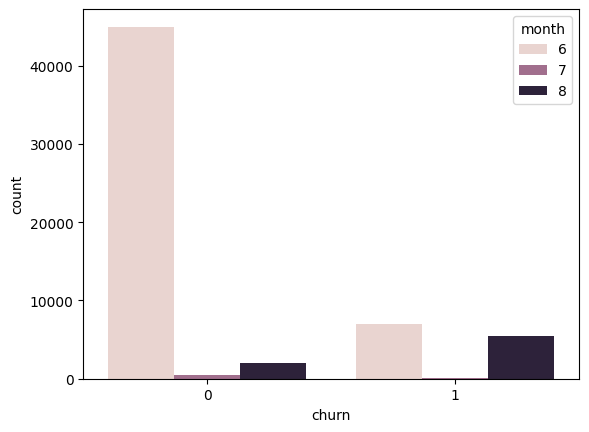

                   user_intake
churn user_intake             
0     0                  45428
      1                   2003
1     0                  12107
      1                    433
##########################################
##########################################


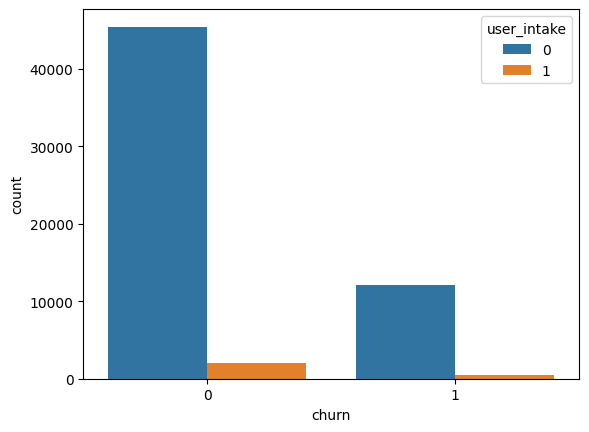

                               user_has_outgoing_calls
churn user_has_outgoing_calls                         
0     0                                           3907
      1                                          43524
1     0                                           7808
      1                                           4732
##########################################
##########################################


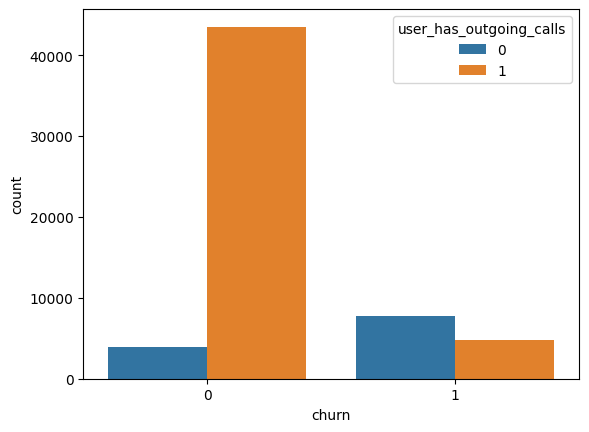

                             user_has_outgoing_sms
churn user_has_outgoing_sms                       
0     0                                      13000
      1                                      34431
1     0                                      10823
      1                                       1717
##########################################
##########################################


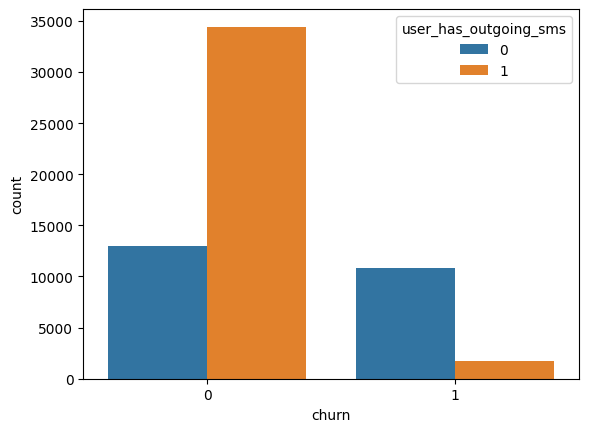

                     user_use_gprs
churn user_use_gprs               
0     0                      44897
      1                       2534
1     0                      12371
      1                        169
##########################################
##########################################


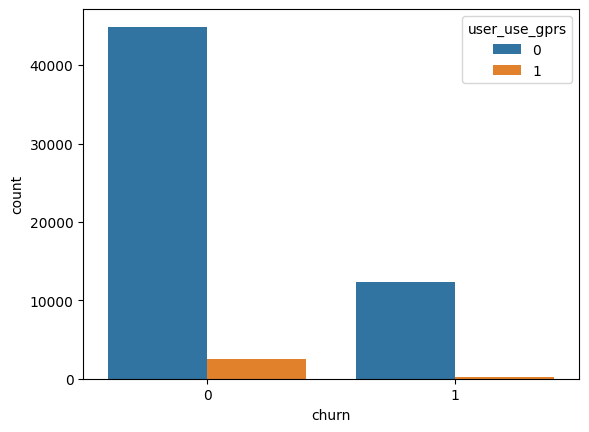

                        user_does_reload
churn user_does_reload                  
0     0                            20314
      1                            27117
1     0                             6054
      1                             6486
##########################################
##########################################


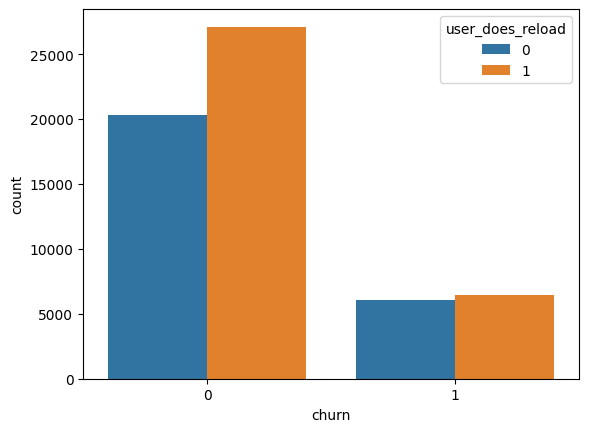

             churn
churn churn       
0     0      47431
1     1      12540
##########################################
##########################################


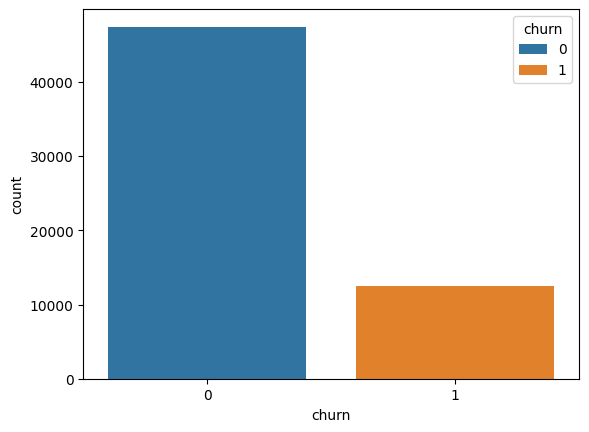

In [77]:
for col in cat_cols:
  eda.cat_summary(df, "churn", plot=True, col_name2=col)

count   59971.000
mean     4012.647
std      6063.051
min         1.000
5%         79.000
10%       177.000
20%       362.000
30%       599.000
40%       886.000
50%      1219.000
60%      1498.000
70%      1978.000
80%     15867.000
90%     15947.000
95%     15947.000
99%     15947.000
max     15947.000
Name: user_lifetime, dtype: float64


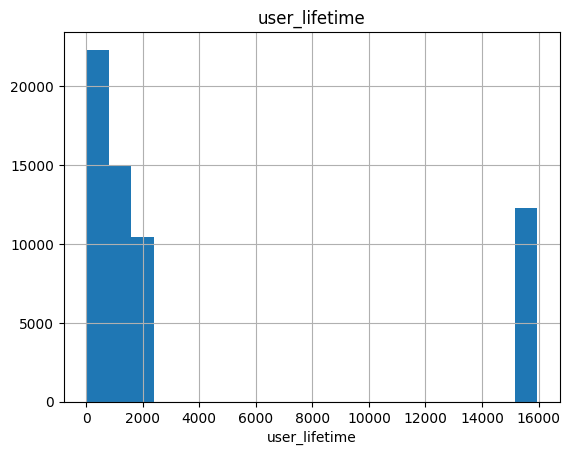

count   59971.000
mean       64.041
std       264.175
min         0.000
5%          1.000
10%         1.000
20%         1.000
30%         1.000
40%         1.000
50%         2.000
60%         3.000
70%         5.000
80%         8.000
90%        27.000
95%        80.000
99%      1276.000
max      1307.000
Name: user_no_outgoing_activity_in_days, dtype: float64


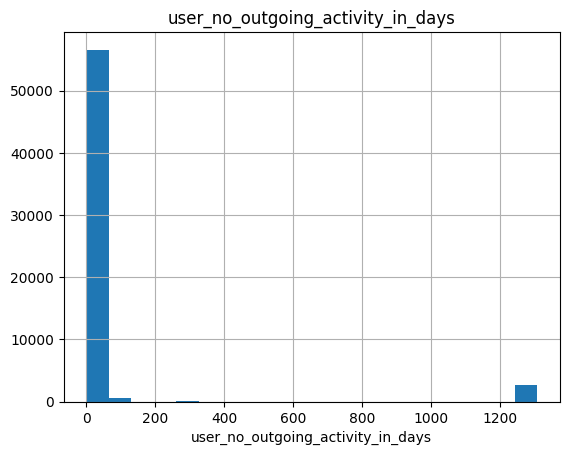

count   59971.000
mean        9.624
std        18.510
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.650
40%         3.060
50%         5.250
60%         7.830
70%        11.130
80%        15.000
90%        24.140
95%        34.215
99%        62.342
max      1775.710
Name: user_account_balance_last, dtype: float64


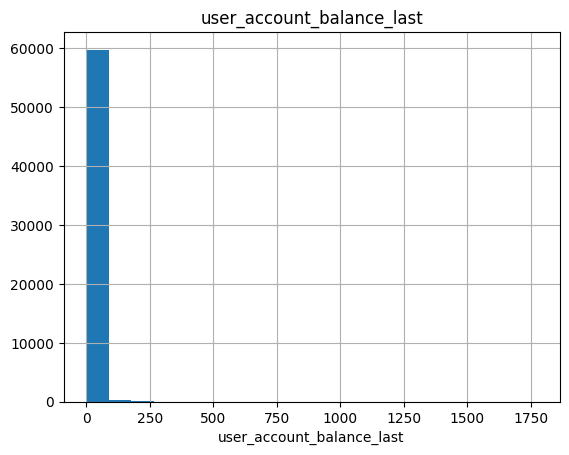

count   59971.000
mean        6.825
std        13.627
min       -30.060
5%          0.000
10%         0.000
20%         0.000
30%         0.010
40%         0.930
50%         2.280
60%         4.070
70%         6.450
80%        10.290
90%        18.110
95%        27.970
99%        60.856
max       510.110
Name: user_spendings, dtype: float64


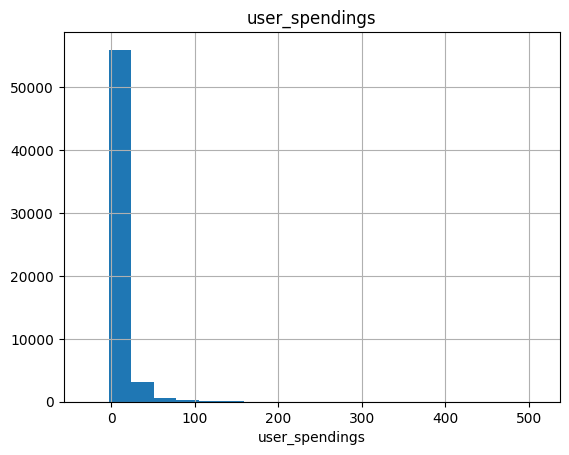

count   59971.000
mean      361.610
std       556.904
min         0.000
5%          1.000
10%         3.000
20%         8.000
30%        11.000
40%        16.000
50%        25.000
60%        41.000
70%        76.000
80%      1276.000
90%      1276.000
95%      1276.000
99%      1276.000
max      1338.000
Name: reloads_inactive_days, dtype: float64


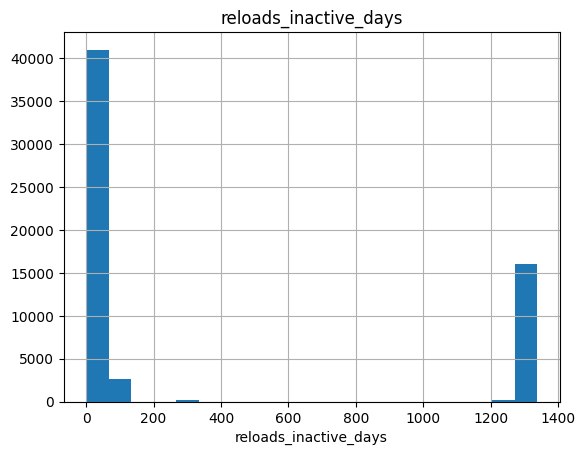

count   59971.000
mean        0.936
std         1.349
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.000
50%         1.000
60%         1.000
70%         1.000
80%         1.000
90%         2.000
95%         3.000
99%         6.000
max        28.000
Name: reloads_count, dtype: float64


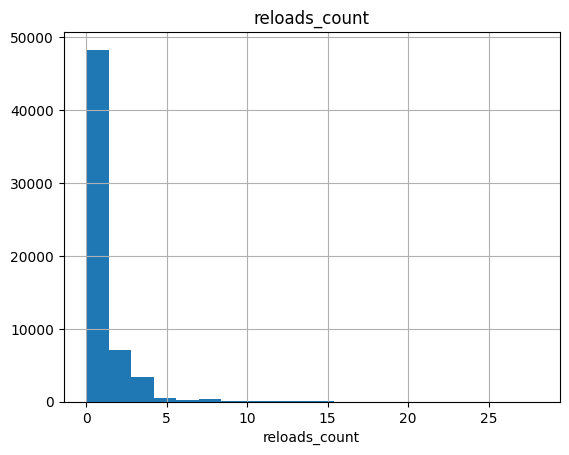

count   59971.000
mean        7.766
std        16.786
min       -17.240
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.000
50%         0.000
60%         4.000
70%         7.500
80%        12.250
90%        24.020
95%        36.030
99%        66.053
max      1500.000
Name: reloads_sum, dtype: float64


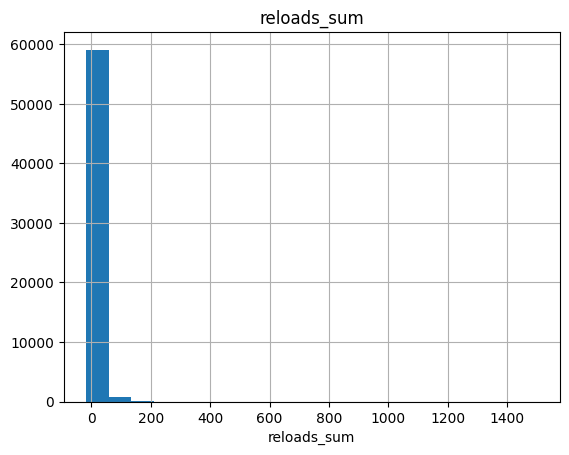

count   59971.000
mean       35.361
std        63.627
min         0.000
5%          0.000
10%         0.000
20%         1.000
30%         4.000
40%         8.000
50%        15.000
60%        23.000
70%        35.000
80%        54.000
90%        91.000
95%       138.000
99%       284.300
max      2495.000
Name: calls_outgoing_count, dtype: float64


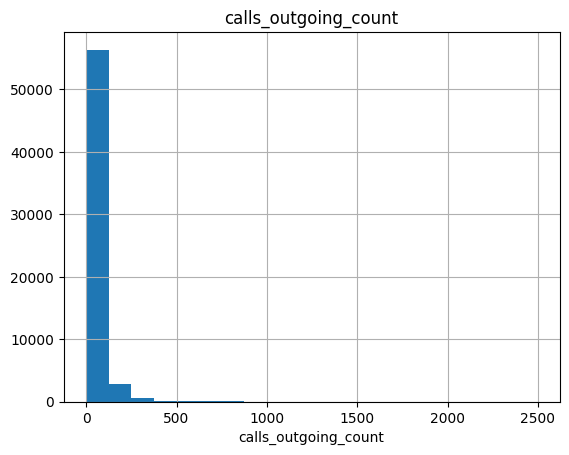

count   59971.000
mean        4.778
std        10.582
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.300
50%         1.010
60%         2.160
70%         3.910
80%         6.830
90%        13.230
95%        21.395
99%        47.388
max       323.810
Name: calls_outgoing_spendings, dtype: float64


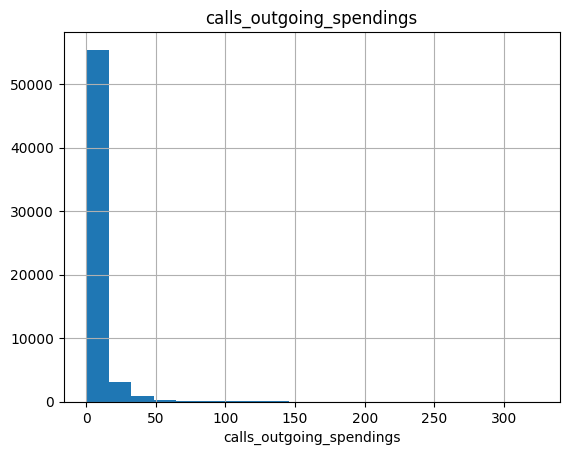

count   59971.000
mean       32.200
std        64.930
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.230
40%         3.420
50%         8.730
60%        16.430
70%        28.620
80%        48.350
90%        89.030
95%       140.490
99%       293.950
max      2494.380
Name: calls_outgoing_duration, dtype: float64


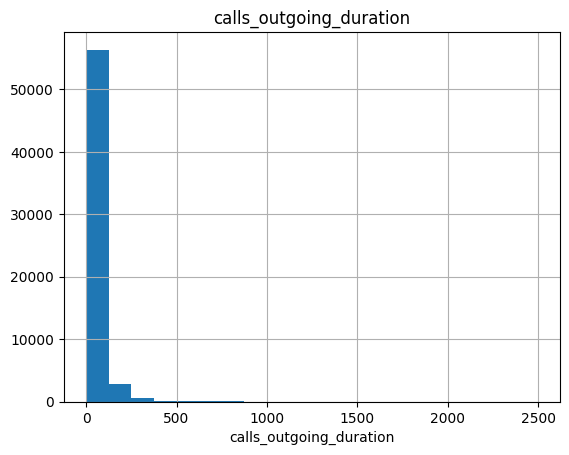

count   59971.000
mean        0.873
std         1.743
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.150
50%         0.260
60%         0.490
70%         0.810
80%         1.300
90%         2.290
95%         3.720
99%         8.000
max        59.400
Name: calls_outgoing_spendings_max, dtype: float64


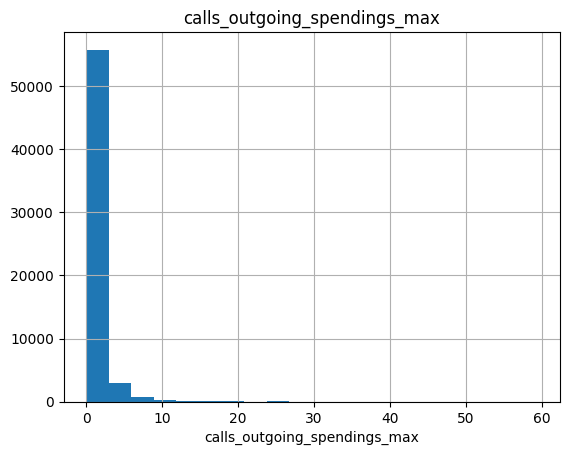

count   59971.000
mean        4.789
std         7.491
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.200
40%         1.000
50%         1.950
60%         3.230
70%         5.100
80%         7.750
90%        12.950
95%        18.850
99%        36.870
max        60.000
Name: calls_outgoing_duration_max, dtype: float64


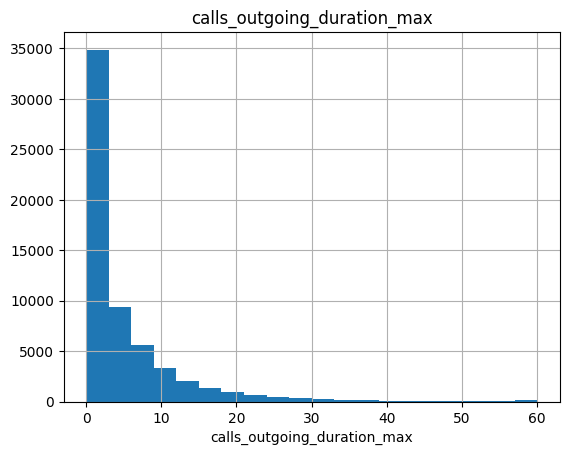

count   59971.000
mean      197.693
std       460.958
min         0.000
5%          1.000
10%         1.000
20%         1.000
30%         2.000
40%         2.000
50%         3.000
60%         5.000
70%        10.000
80%        29.000
90%      1276.000
95%      1338.000
99%      1338.000
max      1338.000
Name: calls_outgoing_inactive_days, dtype: float64


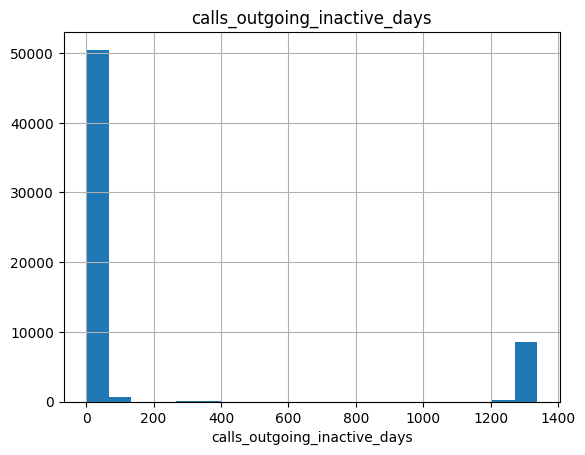

count   59971.000
mean        0.319
std         2.456
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.000
50%         0.000
60%         0.000
70%         0.000
80%         0.000
90%         0.000
95%         1.000
99%         8.000
max       191.000
Name: calls_outgoing_to_onnet_count, dtype: float64


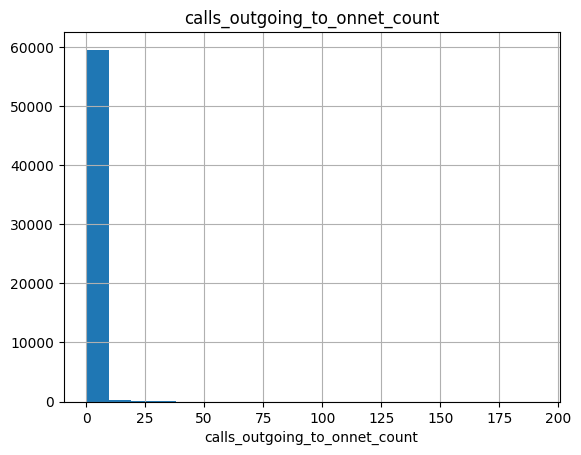

count   59971.000
mean        0.158
std         1.656
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.000
50%         0.000
60%         0.000
70%         0.000
80%         0.000
90%         0.000
95%         0.180
99%         4.110
max       187.670
Name: calls_outgoing_to_onnet_spendings, dtype: float64


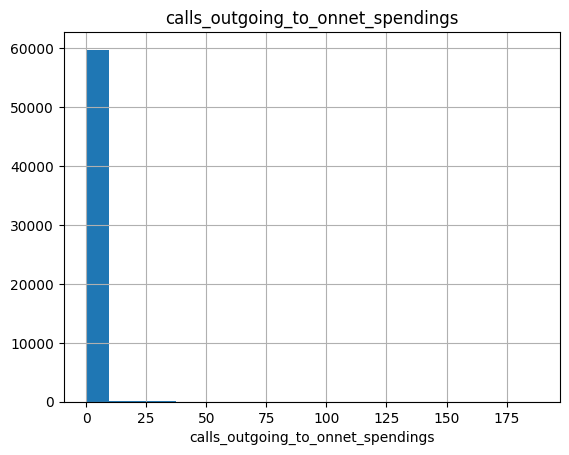

count   59971.000
mean        0.407
std         3.841
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.000
50%         0.000
60%         0.000
70%         0.000
80%         0.000
90%         0.000
95%         0.500
99%        10.623
max       229.950
Name: calls_outgoing_to_onnet_duration, dtype: float64


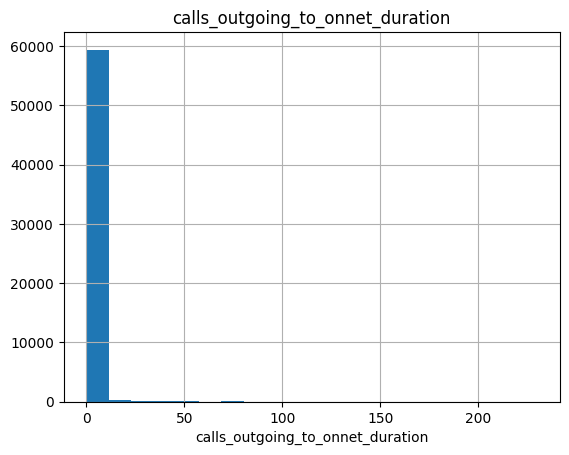

count   59971.000
mean      197.693
std       460.958
min         0.000
5%          1.000
10%         1.000
20%         1.000
30%         2.000
40%         2.000
50%         3.000
60%         5.000
70%        10.000
80%        29.000
90%      1276.000
95%      1338.000
99%      1338.000
max      1338.000
Name: calls_outgoing_to_onnet_inactive_days, dtype: float64


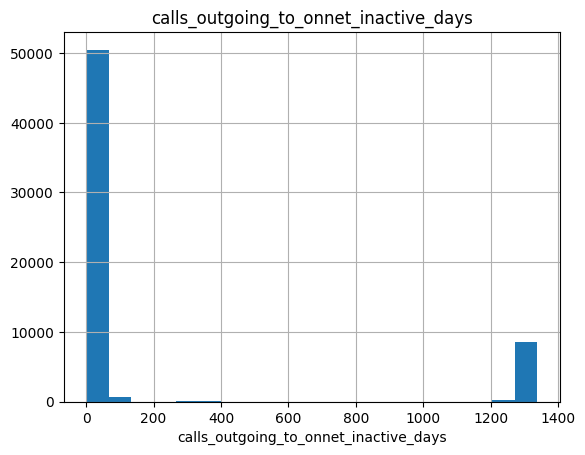

count   59971.000
mean       16.329
std        33.963
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         2.000
50%         4.000
60%         8.000
70%        14.000
80%        24.000
90%        45.000
95%        71.000
99%       151.000
max      1319.000
Name: calls_outgoing_to_offnet_count, dtype: float64


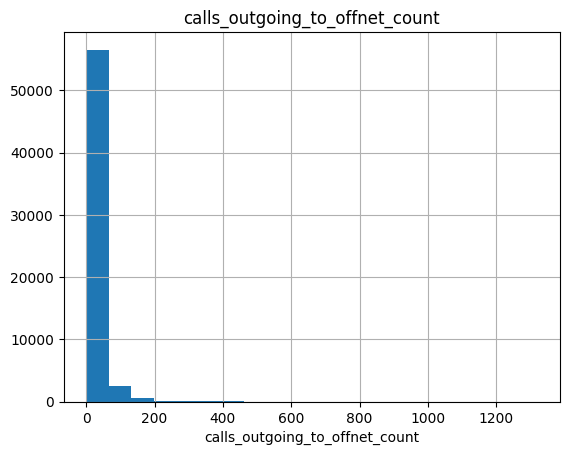

count   59971.000
mean        2.939
std         6.353
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.150
50%         0.470
60%         1.200
70%         2.310
80%         4.270
90%         8.390
95%        13.780
99%        28.913
max       162.280
Name: calls_outgoing_to_offnet_spendings, dtype: float64


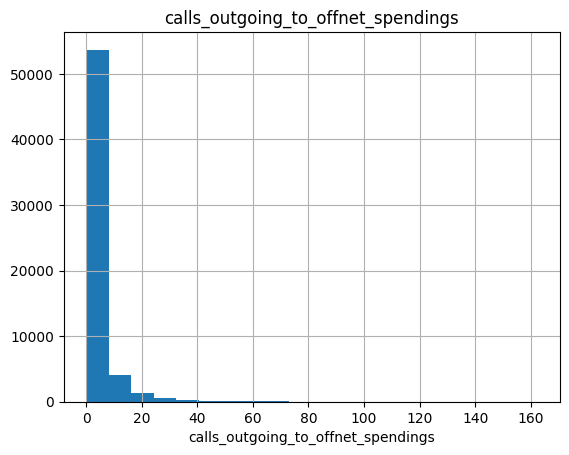

count   59971.000
mean       21.284
std        49.811
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         1.000
50%         3.420
60%         8.220
70%        16.120
80%        29.950
90%        59.820
95%        98.950
99%       214.904
max      2416.000
Name: calls_outgoing_to_offnet_duration, dtype: float64


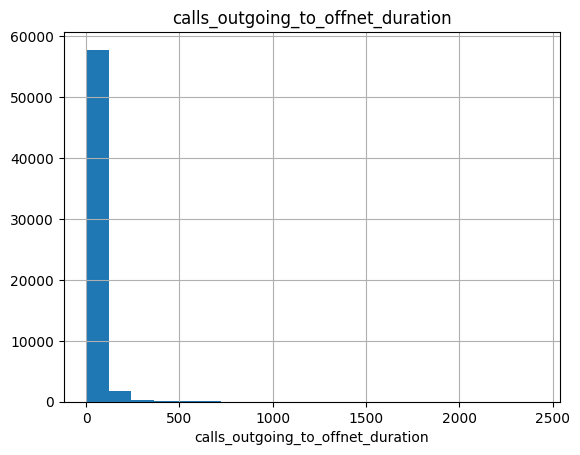

count   59971.000
mean      197.693
std       460.958
min         0.000
5%          1.000
10%         1.000
20%         1.000
30%         2.000
40%         2.000
50%         3.000
60%         5.000
70%        10.000
80%        29.000
90%      1276.000
95%      1338.000
99%      1338.000
max      1338.000
Name: calls_outgoing_to_offnet_inactive_days, dtype: float64


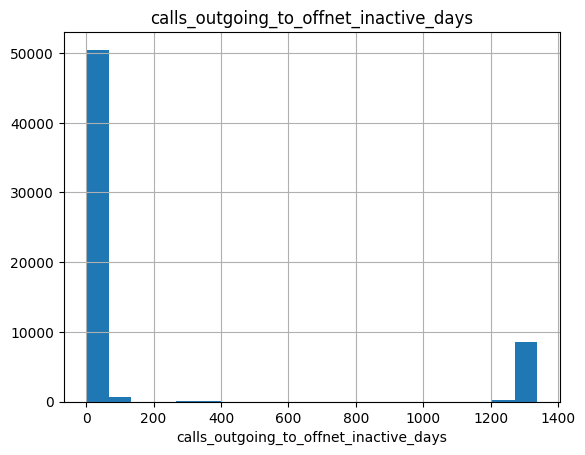

count   59971.000
mean        1.486
std        13.047
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.000
50%         0.000
60%         0.000
70%         0.000
80%         0.000
90%         2.000
95%         7.000
99%        30.000
max      2326.000
Name: calls_outgoing_to_abroad_count, dtype: float64


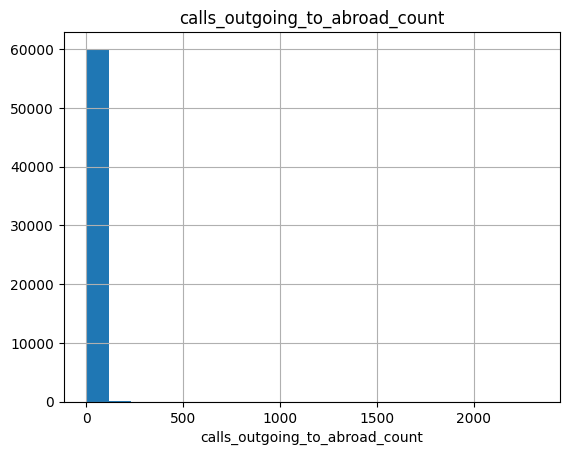

count   59971.000
mean        0.303
std         2.659
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.000
50%         0.000
60%         0.000
70%         0.000
80%         0.000
90%         0.000
95%         0.820
99%         7.333
max       207.100
Name: calls_outgoing_to_abroad_spendings, dtype: float64


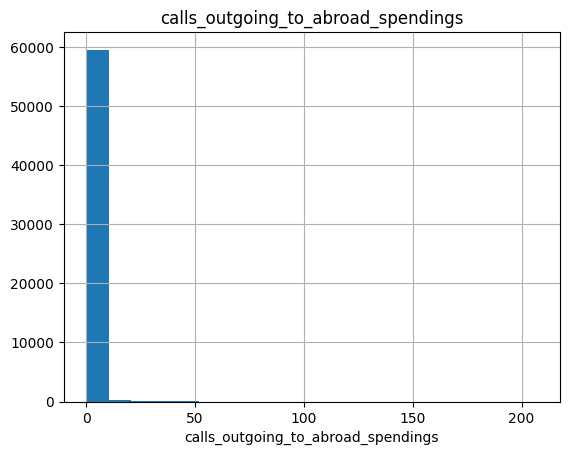

count   59971.000
mean        1.185
std         9.636
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.000
50%         0.000
60%         0.000
70%         0.000
80%         0.000
90%         0.000
95%         3.480
99%        28.873
max       761.400
Name: calls_outgoing_to_abroad_duration, dtype: float64


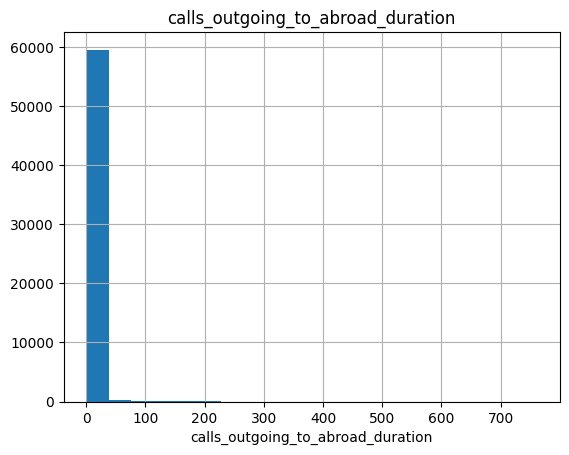

count   59971.000
mean      197.693
std       460.958
min         0.000
5%          1.000
10%         1.000
20%         1.000
30%         2.000
40%         2.000
50%         3.000
60%         5.000
70%        10.000
80%        29.000
90%      1276.000
95%      1338.000
99%      1338.000
max      1338.000
Name: calls_outgoing_to_abroad_inactive_days, dtype: float64


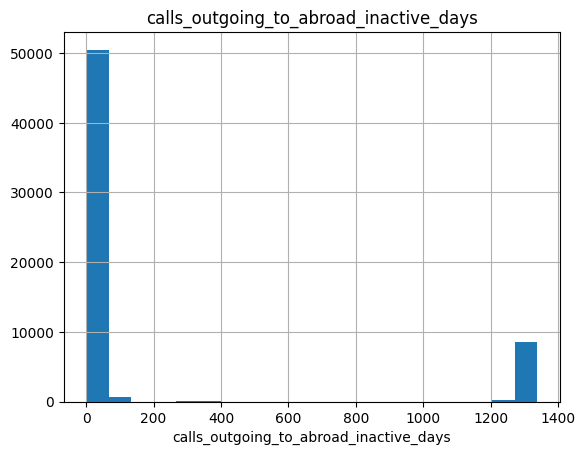

count   59971.000
mean       34.376
std        91.774
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         1.000
50%         3.000
60%        10.000
70%        21.000
80%        43.000
90%        94.000
95%       161.000
99%       407.000
max      3391.000
Name: sms_outgoing_count, dtype: float64


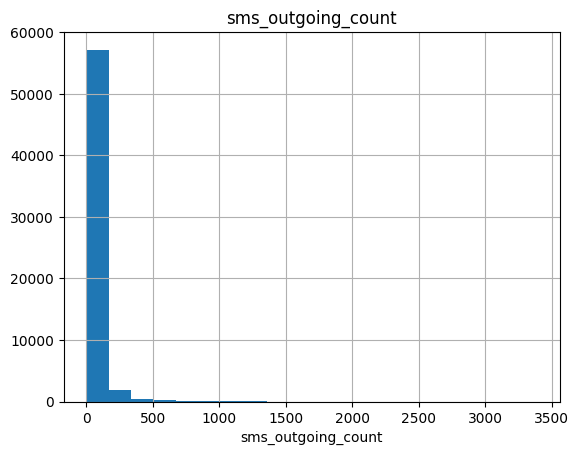

count   59971.000
mean        1.856
std         6.022
min       -11.530
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.000
50%         0.120
60%         0.450
70%         1.080
80%         2.280
90%         4.980
95%         8.500
99%        22.349
max       422.240
Name: sms_outgoing_spendings, dtype: float64


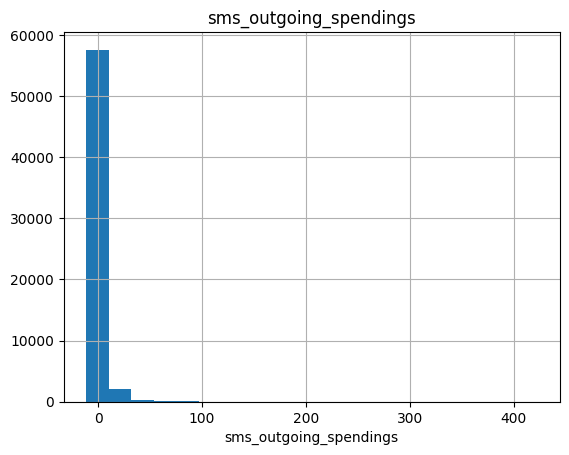

count   59971.000
mean        0.086
std         0.280
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.000
50%         0.060
60%         0.060
70%         0.060
80%         0.090
90%         0.110
95%         0.250
99%         1.000
max         4.000
Name: sms_outgoing_spendings_max, dtype: float64


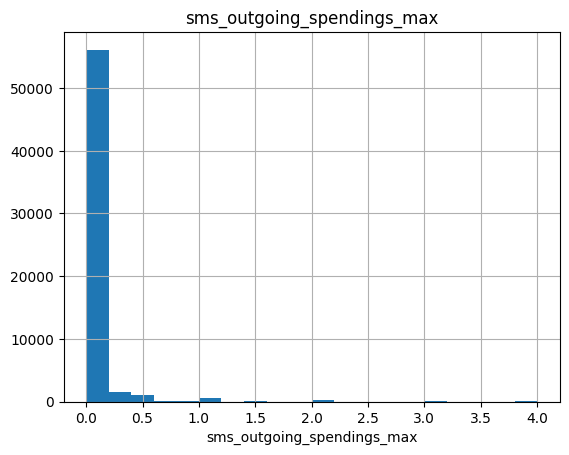

count   59971.000
mean      411.730
std       595.833
min         0.000
5%          1.000
10%         1.000
20%         1.000
30%         2.000
40%         4.000
50%        10.000
60%        30.000
70%      1276.000
80%      1276.000
90%      1338.000
95%      1338.000
99%      1338.000
max      1338.000
Name: sms_outgoing_inactive_days, dtype: float64


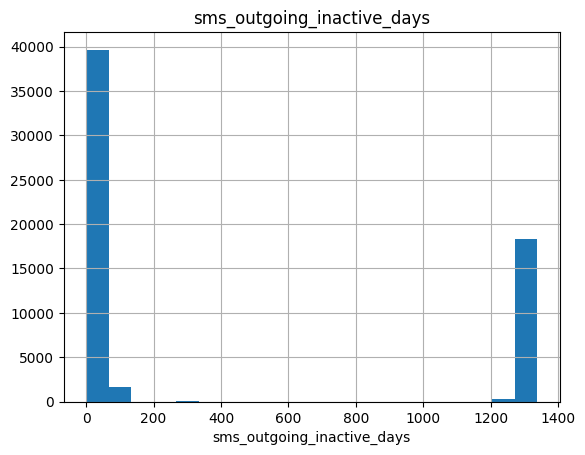

count   59971.000
mean        2.487
std        13.189
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.000
50%         0.000
60%         0.000
70%         0.000
80%         1.000
90%         5.000
95%        12.000
99%        45.000
max       922.000
Name: sms_outgoing_to_onnet_count, dtype: float64


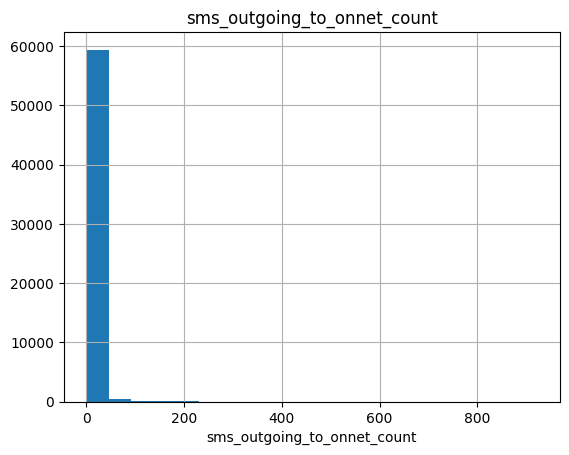

count   59971.000
mean        0.126
std         0.661
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.000
50%         0.000
60%         0.000
70%         0.000
80%         0.000
90%         0.240
95%         0.660
99%         2.340
max        51.600
Name: sms_outgoing_to_onnet_spendings, dtype: float64


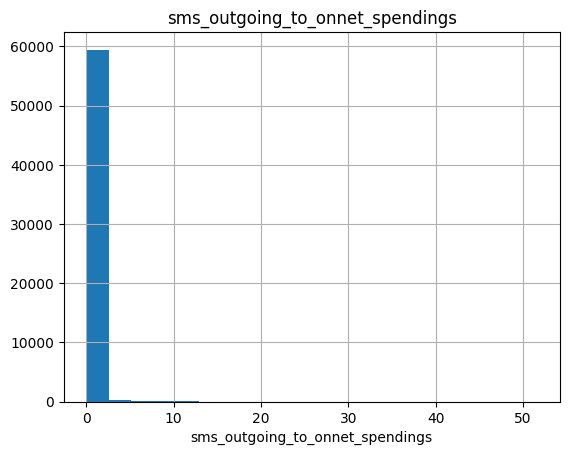

count   59971.000
mean      411.730
std       595.833
min         0.000
5%          1.000
10%         1.000
20%         1.000
30%         2.000
40%         4.000
50%        10.000
60%        30.000
70%      1276.000
80%      1276.000
90%      1338.000
95%      1338.000
99%      1338.000
max      1338.000
Name: sms_outgoing_to_onnet_inactive_days, dtype: float64


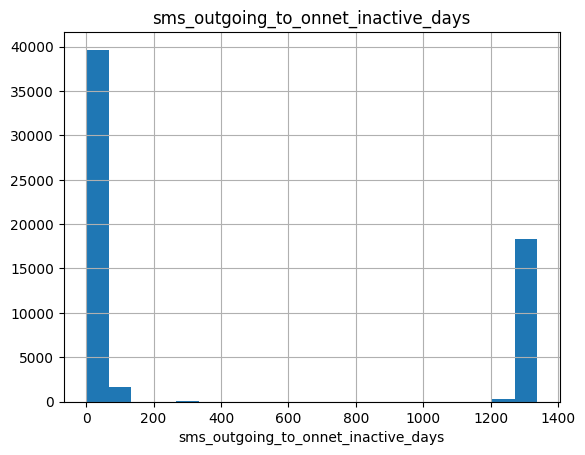

count   59971.000
mean       21.547
std        67.030
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.000
50%         1.000
60%         3.000
70%        10.000
80%        23.000
90%        57.000
95%       106.000
99%       293.000
max      2940.000
Name: sms_outgoing_to_offnet_count, dtype: float64


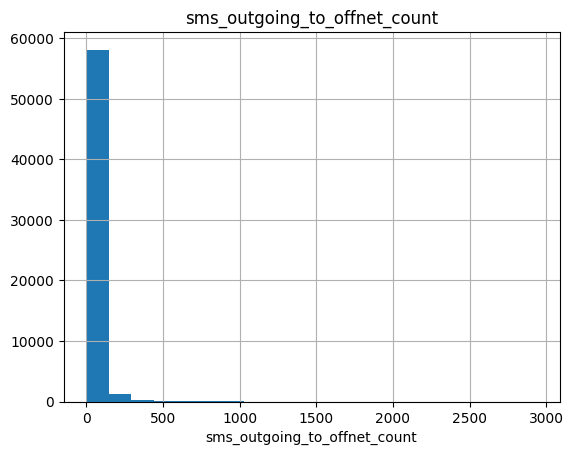

count   59971.000
mean        1.259
std         3.946
min       -11.530
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.000
50%         0.000
60%         0.180
70%         0.540
80%         1.320
90%         3.360
95%         6.180
99%        17.100
max       173.580
Name: sms_outgoing_to_offnet_spendings, dtype: float64


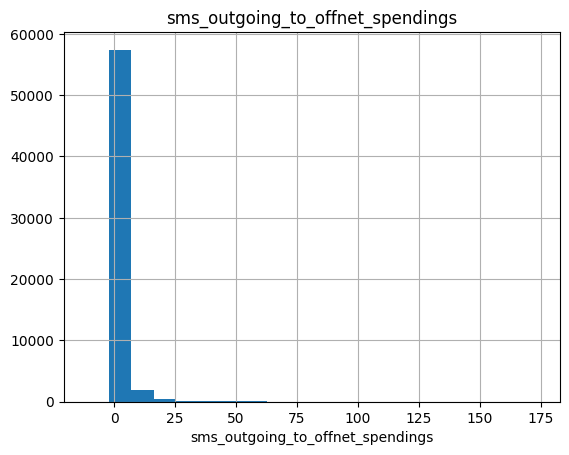

count   59971.000
mean      411.730
std       595.833
min         0.000
5%          1.000
10%         1.000
20%         1.000
30%         2.000
40%         4.000
50%        10.000
60%        30.000
70%      1276.000
80%      1276.000
90%      1338.000
95%      1338.000
99%      1338.000
max      1338.000
Name: sms_outgoing_to_offnet_inactive_days, dtype: float64


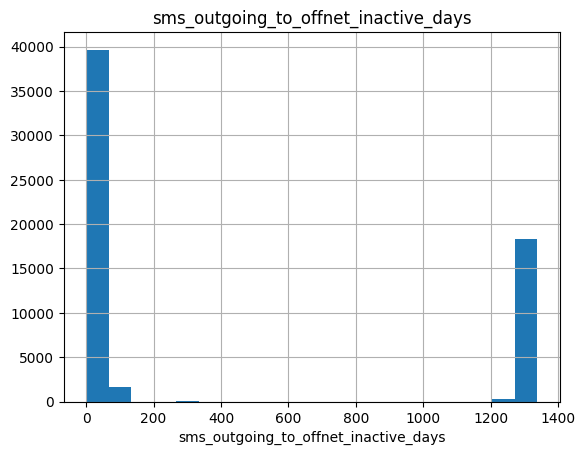

count   59971.000
mean        1.004
std         7.119
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.000
50%         0.000
60%         0.000
70%         0.000
80%         0.000
90%         0.000
95%         4.000
99%        23.000
max       384.000
Name: sms_outgoing_to_abroad_count, dtype: float64


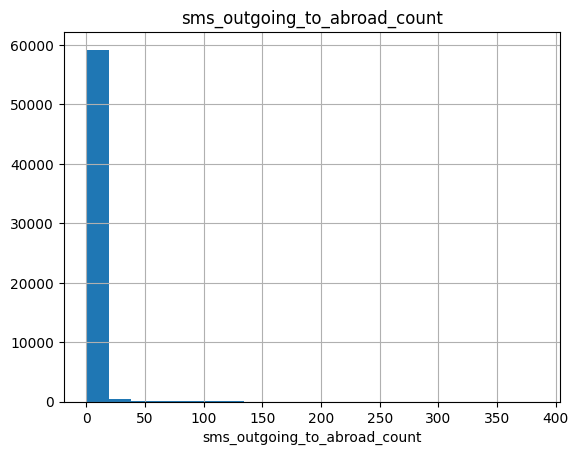

count   59971.000
mean        0.127
std         1.019
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.000
50%         0.000
60%         0.000
70%         0.000
80%         0.000
90%         0.000
95%         0.440
99%         2.825
max        81.620
Name: sms_outgoing_to_abroad_spendings, dtype: float64


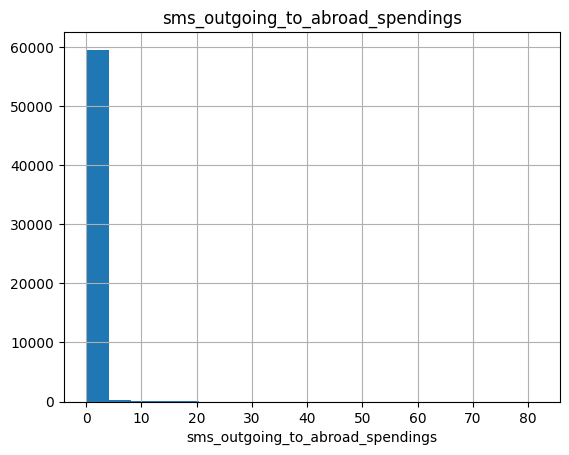

count   59971.000
mean      411.730
std       595.833
min         0.000
5%          1.000
10%         1.000
20%         1.000
30%         2.000
40%         4.000
50%        10.000
60%        30.000
70%      1276.000
80%      1276.000
90%      1338.000
95%      1338.000
99%      1338.000
max      1338.000
Name: sms_outgoing_to_abroad_inactive_days, dtype: float64


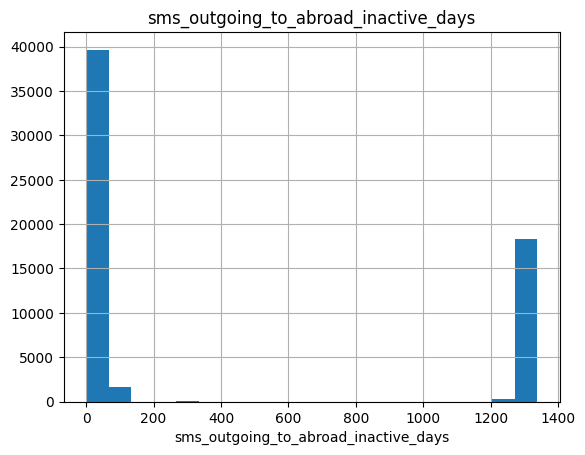

count   59971.000
mean        8.959
std        14.196
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         2.000
40%         4.000
50%         6.000
60%         8.000
70%        11.000
80%        14.000
90%        21.000
95%        28.000
99%        56.000
max       716.000
Name: sms_incoming_count, dtype: float64


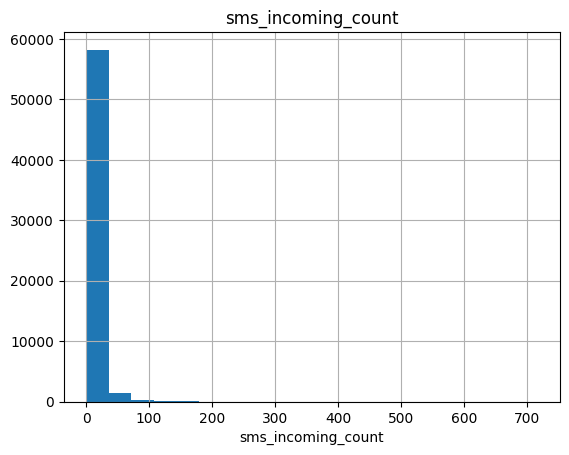

count   59971.000
mean        0.122
std         1.418
min        -3.700
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.000
50%         0.000
60%         0.000
70%         0.000
80%         0.000
90%         0.000
95%         0.000
99%         3.000
max        98.000
Name: sms_incoming_spendings, dtype: float64


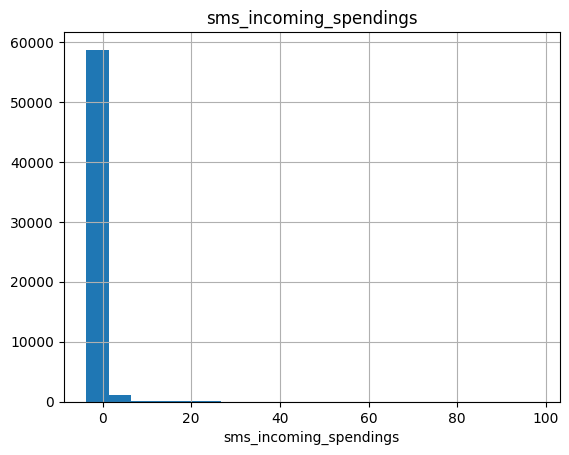

count   59971.000
mean        0.798
std         3.149
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.000
50%         0.000
60%         0.000
70%         0.000
80%         1.000
90%         2.000
95%         4.000
99%        12.000
max       306.000
Name: sms_incoming_from_abroad_count, dtype: float64


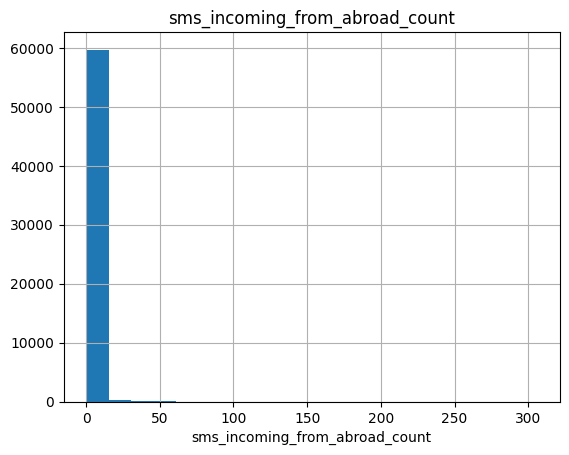

count   59971.000
mean        0.001
std         0.081
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.000
50%         0.000
60%         0.000
70%         0.000
80%         0.000
90%         0.000
95%         0.000
99%         0.000
max        10.000
Name: sms_incoming_from_abroad_spendings, dtype: float64


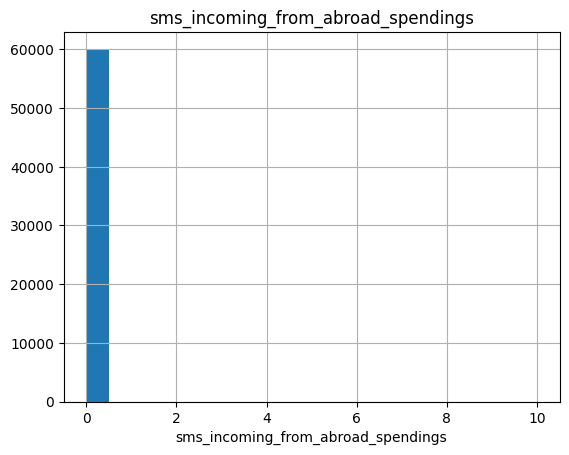

count   59971.000
mean        6.117
std        87.459
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.000
50%         0.000
60%         0.000
70%         0.000
80%         0.000
90%         0.000
95%         0.000
99%       128.000
max      9024.000
Name: gprs_session_count, dtype: float64


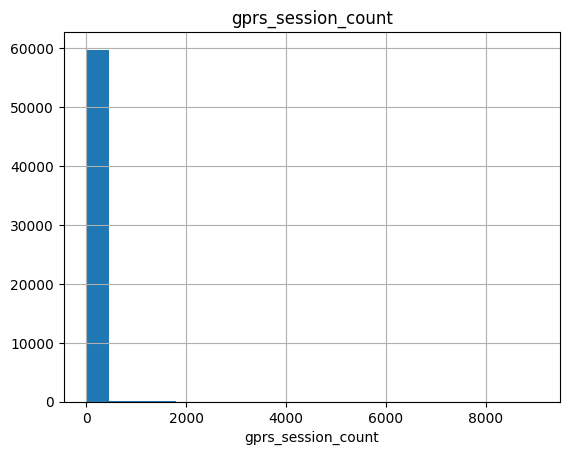

count   59971.000
mean        1.748
std        34.044
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.000
50%         0.000
60%         0.000
70%         0.000
80%         0.000
90%         0.000
95%         0.000
99%        29.875
max      4730.960
Name: gprs_usage, dtype: float64


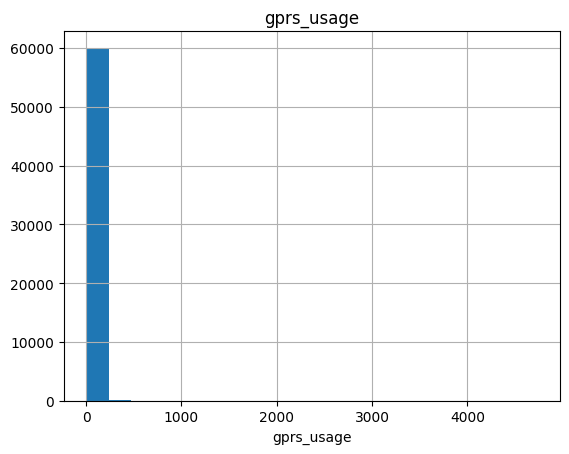

count   59971.000
mean        0.191
std         2.707
min       -38.900
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.000
50%         0.000
60%         0.000
70%         0.000
80%         0.000
90%         0.000
95%         0.000
99%         3.500
max       255.400
Name: gprs_spendings, dtype: float64


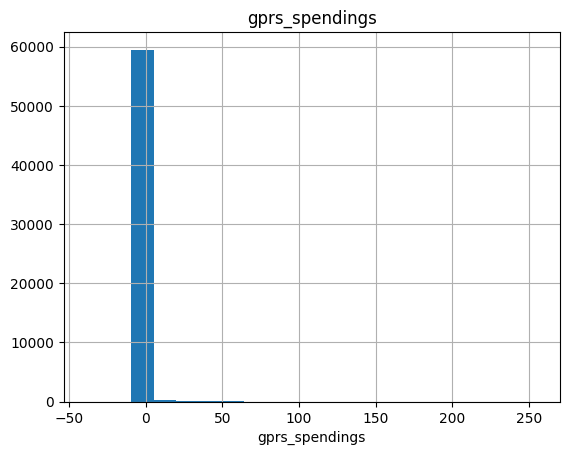

count   59971.000
mean     1188.246
std       333.894
min         0.000
5%         40.000
10%      1276.000
20%      1276.000
30%      1276.000
40%      1276.000
50%      1276.000
60%      1276.000
70%      1276.000
80%      1276.000
90%      1338.000
95%      1338.000
99%      1338.000
max      1338.000
Name: gprs_inactive_days, dtype: float64


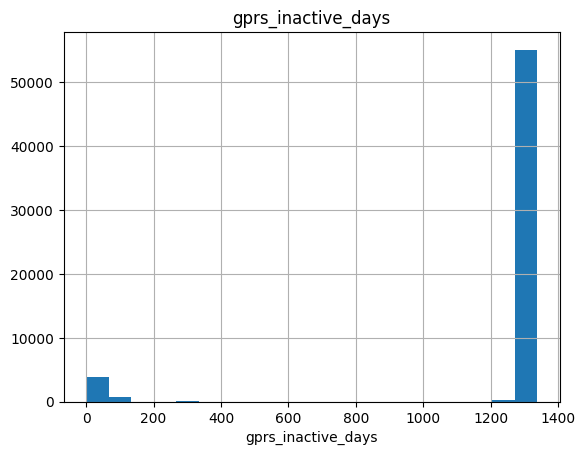

count   59971.000
mean        3.347
std         6.010
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         1.000
40%         1.000
50%         1.000
60%         2.000
70%         3.000
80%         5.000
90%         8.000
95%        12.000
99%        26.000
max       236.000
Name: last_100_reloads_count, dtype: float64


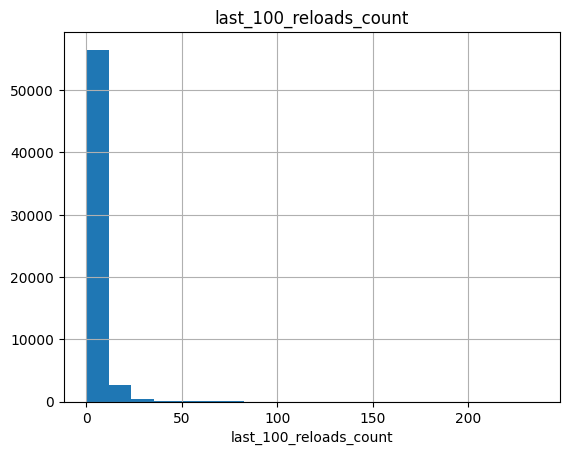

count   59971.000
mean       21.830
std        42.593
min       -17.239
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         1.500
50%        12.000
60%        15.000
70%        24.000
80%        34.250
90%        58.015
95%        86.030
99%       179.927
max      3000.000
Name: last_100_reloads_sum, dtype: float64


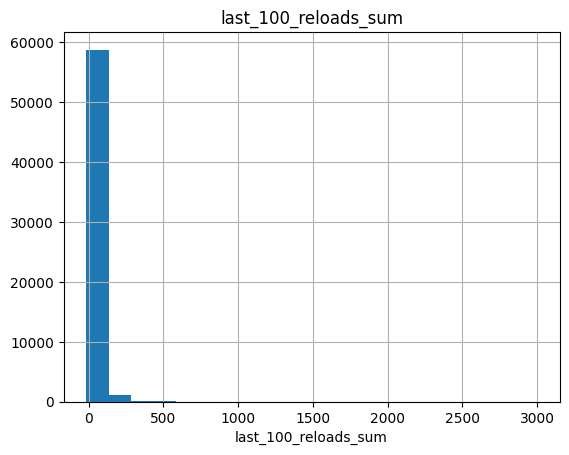

count   59971.000
mean       98.690
std       193.307
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         4.550
40%        15.300
50%        30.750
60%        53.920
70%        87.720
80%       144.430
90%       269.280
95%       420.880
99%       877.490
max      4953.120
Name: last_100_calls_outgoing_duration, dtype: float64


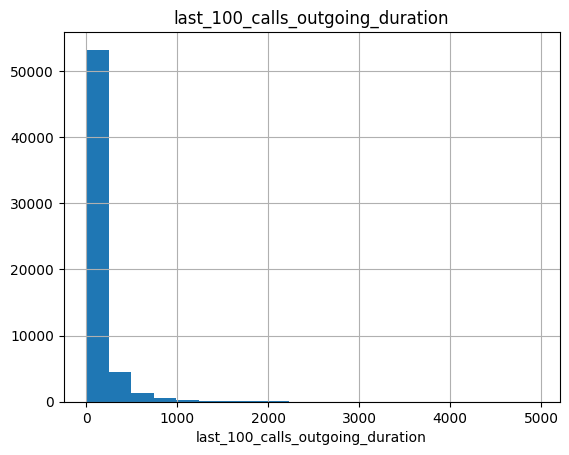

count   59971.000
mean        1.027
std         7.483
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.000
50%         0.000
60%         0.000
70%         0.000
80%         0.000
90%         0.500
95%         3.720
99%        23.836
max       473.250
Name: last_100_calls_outgoing_to_onnet_duration, dtype: float64


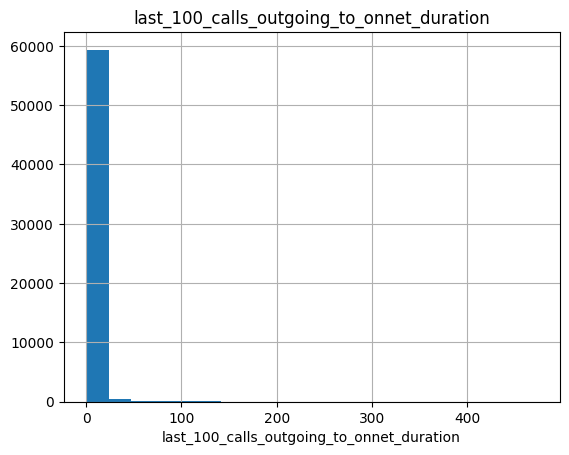

count   59971.000
mean       66.991
std       149.767
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         1.000
40%         6.000
50%        15.420
60%        29.770
70%        53.030
80%        92.250
90%       184.570
95%       302.185
99%       659.130
max      4772.370
Name: last_100_calls_outgoing_to_offnet_duration, dtype: float64


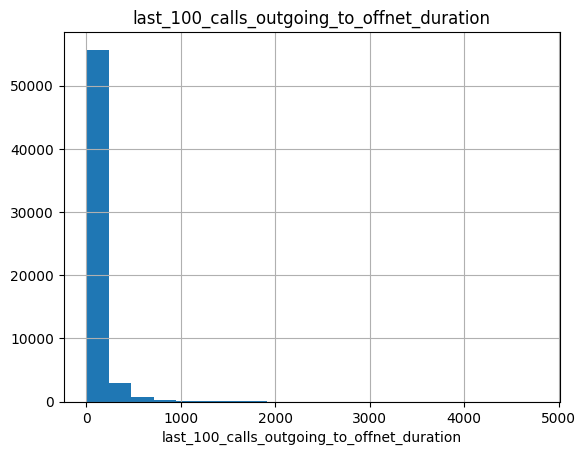

count   59971.000
mean        3.018
std        19.651
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.000
50%         0.000
60%         0.000
70%         0.000
80%         0.000
90%         4.000
95%        13.090
99%        59.154
max      1149.120
Name: last_100_calls_outgoing_to_abroad_duration, dtype: float64


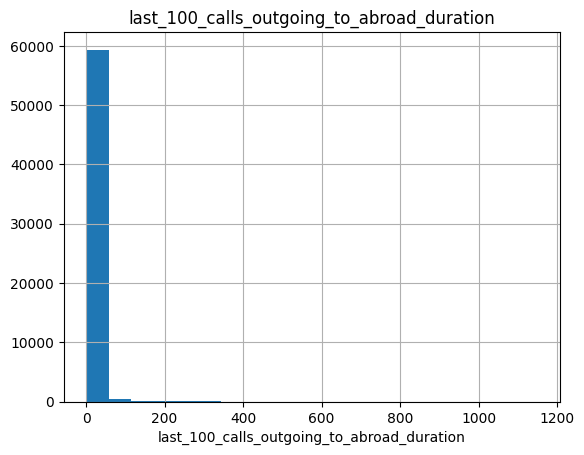

count   59971.000
mean      101.561
std       264.869
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         4.000
50%        14.000
60%        33.000
70%        68.000
80%       133.000
90%       278.000
95%       463.000
99%      1138.000
max     18637.000
Name: last_100_sms_outgoing_count, dtype: float64


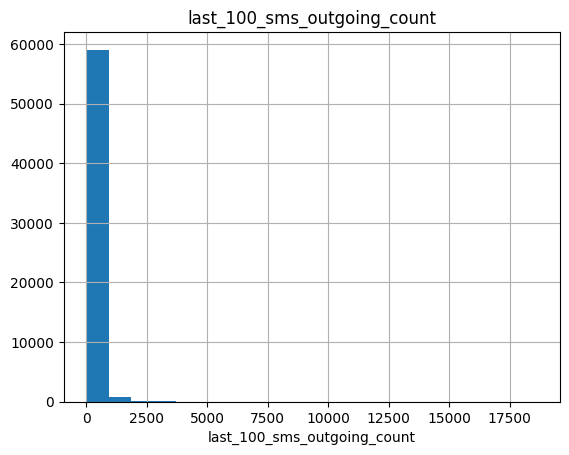

count   59971.000
mean        7.277
std        35.772
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.000
50%         0.000
60%         0.000
70%         0.000
80%         3.000
90%        15.000
95%        36.000
99%       123.000
max      2829.000
Name: last_100_sms_outgoing_to_onnet_count, dtype: float64


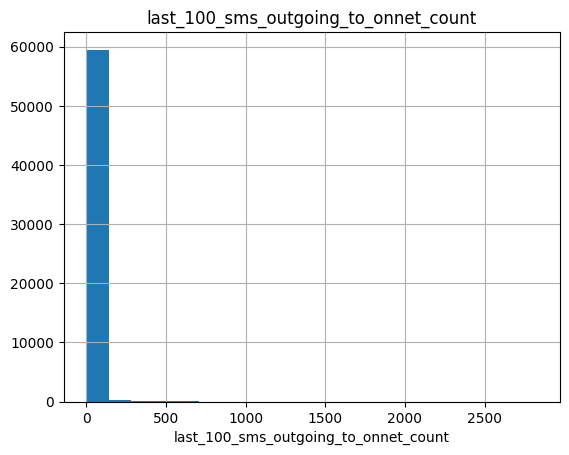

count   59971.000
mean       62.477
std       187.120
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         1.000
50%         5.000
60%        15.000
70%        35.000
80%        75.000
90%       168.000
95%       295.000
99%       767.300
max     13860.000
Name: last_100_sms_outgoing_to_offnet_count, dtype: float64


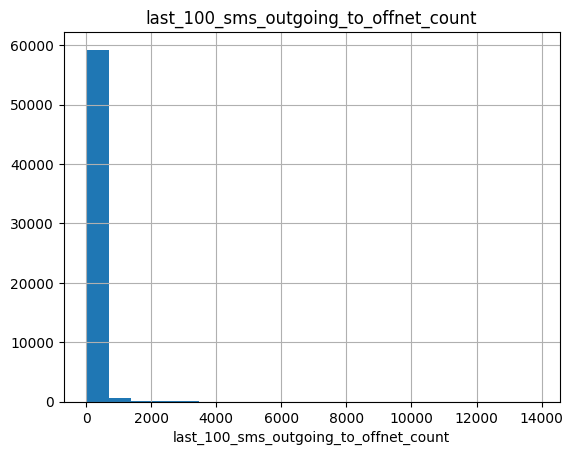

count   59971.000
mean        3.051
std        25.570
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.000
50%         0.000
60%         0.000
70%         0.000
80%         0.000
90%         5.000
95%        14.000
99%        56.000
max      4692.000
Name: last_100_sms_outgoing_to_abroad_count, dtype: float64


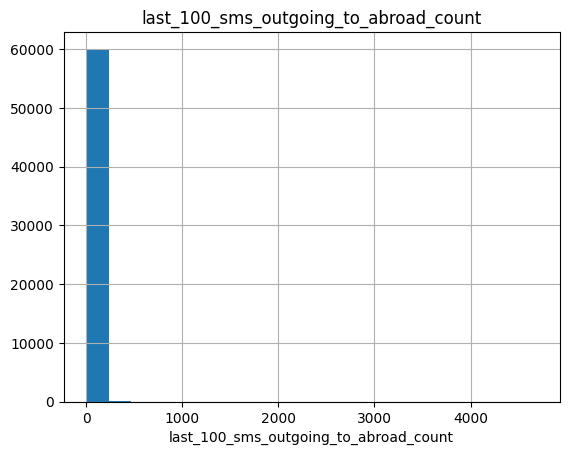

count   59971.000
mean        5.663
std        71.611
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.000
50%         0.000
60%         0.000
70%         0.000
80%         0.000
90%         0.000
95%         1.585
99%       127.393
max      5571.220
Name: last_100_gprs_usage, dtype: float64


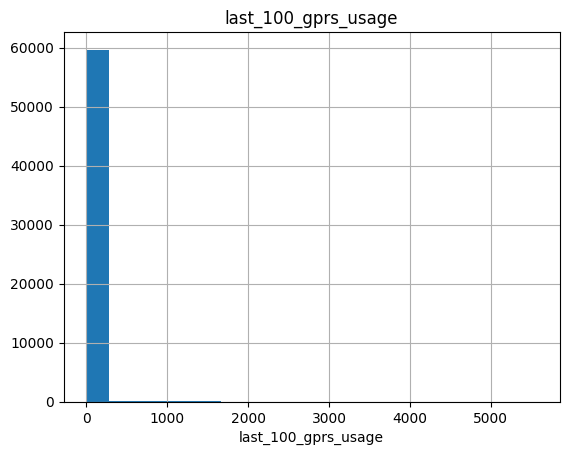

In [78]:
for num_col in num_cols:
  eda.num_summary(df, num_col, plot=True)

In [79]:
for cat_col in cat_cols:
  eda.target_summary_with_cat(df, "churn", cat_col)

       TARGET_MEAN
month             
6            0.136
7            0.167
8            0.725


             TARGET_MEAN
user_intake             
0                  0.210
1                  0.178


                         TARGET_MEAN
user_has_outgoing_calls             
0                              0.666
1                              0.098


                       TARGET_MEAN
user_has_outgoing_sms             
0                            0.454
1                            0.047


               TARGET_MEAN
user_use_gprs             
0                    0.216
1                    0.063


                  TARGET_MEAN
user_does_reload             
0                       0.230
1                       0.193


       TARGET_MEAN
churn             
0            0.000
1            1.000




In [80]:
for num_col in num_cols:
  eda.target_summary_with_num(df, "churn", num_col)

       user_lifetime
churn               
0           2360.828
1          10260.450


       user_no_outgoing_activity_in_days
churn                                   
0                                 33.833
1                                178.297


       user_account_balance_last
churn                           
0                         11.320
1                          3.213


       user_spendings
churn                
0               8.301
1               1.244


       reloads_inactive_days
churn                       
0                    323.791
1                    504.656


       reloads_count
churn               
0              1.029
1              0.584


       reloads_sum
churn             
0            9.416
1            1.523


       calls_outgoing_count
churn                      
0                    42.853
1                     7.027


       calls_outgoing_spendings
churn                          
0                         5.832
1                         0.794


##Data Prep

In [89]:
#@title Feature Engineering
df["average_monthly_spending"] = df["user_spendings"] / df["user_lifetime"]
df["average_usage_rate"] = (df["calls_outgoing_count"] + df["sms_outgoing_count"] + df["gprs_session_count"] + df["reloads_count"]) / df["user_lifetime"]
df["average_calls_outgoing_count"] = df["calls_outgoing_count"] / df["user_lifetime"]
df["average_sms_outgoing_count"] = df["sms_outgoing_count"] / df["user_lifetime"]
df["average_gprs_session_count"] = df["gprs_session_count"] / df["user_lifetime"]


In [91]:
data_prep.check_missing_value(df)

False

In [92]:
df.dropna(inplace=True)

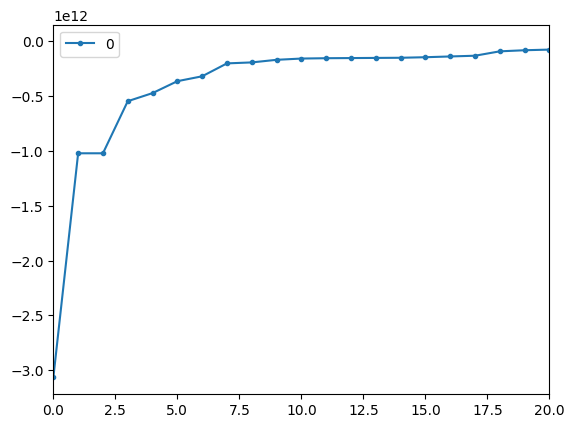

In [93]:
data_prep.remove_outlier_with_lof(df, num_cols, inplace=True)

In [13]:
for cat_col in cat_cols:
  print(df[cat_col].value_counts())

month
6    52023
8     7450
7      524
Name: count, dtype: int64
user_intake
0    57532
1     2465
Name: count, dtype: int64
user_has_outgoing_calls
1    48281
0    11716
Name: count, dtype: int64
user_has_outgoing_sms
1    36167
0    23830
Name: count, dtype: int64
user_use_gprs
0    57292
1     2705
Name: count, dtype: int64
user_does_reload
1    33627
0    26370
Name: count, dtype: int64
churn
0    47449
1    12548
Name: count, dtype: int64


In [94]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
month,59968.000,6.257,0.663,6.000,6.000,6.000,6.000,8.000
user_lifetime,59968.000,4012.052,6062.619,1.000,457.000,1219.000,1985.000,15947.000
user_intake,59968.000,0.041,0.197,0.000,0.000,0.000,0.000,1.000
user_no_outgoing_activity_in_days,59968.000,63.996,264.082,0.000,1.000,2.000,8.000,1276.000
user_account_balance_last,59968.000,9.625,18.510,0.000,0.040,5.250,12.900,1775.710
...,...,...,...,...,...,...,...,...
average_monthly_spending,59968.000,0.040,0.387,-1.582,0.000,0.002,0.011,51.000
average_usage_rate,59968.000,0.462,5.236,0.000,0.002,0.030,0.127,605.000
average_calls_outgoing_count,59968.000,0.189,1.569,0.000,0.001,0.015,0.062,265.000
average_sms_outgoing_count,59968.000,0.188,2.742,0.000,0.000,0.004,0.040,521.000


In [95]:
df = data_prep.one_hot_encoder(df, ["month"])

In [96]:
df = df.sample(frac=1).reset_index(drop=True)

In [97]:
y = df.churn
X = df.drop(["churn"], axis=1)
X.head()

,user_lifetime,user_intake,user_no_outgoing_activity_in_days,user_account_balance_last,user_spendings,user_has_outgoing_calls,user_has_outgoing_sms,user_use_gprs,user_does_reload,reloads_inactive_days,reloads_count,reloads_sum,calls_outgoing_count,calls_outgoing_spendings,calls_outgoing_duration,calls_outgoing_spendings_max,calls_outgoing_duration_max,calls_outgoing_inactive_days,calls_outgoing_to_onnet_count,calls_outgoing_to_onnet_spendings,calls_outgoing_to_onnet_duration,calls_outgoing_to_onnet_inactive_days,calls_outgoing_to_offnet_count,calls_outgoing_to_offnet_spendings,calls_outgoing_to_offnet_duration,calls_outgoing_to_offnet_inactive_days,calls_outgoing_to_abroad_count,calls_outgoing_to_abroad_spendings,calls_outgoing_to_abroad_duration,calls_outgoing_to_abroad_inactive_days,sms_outgoing_count,sms_outgoing_spendings,sms_outgoing_spendings_max,sms_outgoing_inactive_days,sms_outgoing_to_onnet_count,sms_outgoing_to_onnet_spendings,sms_outgoing_to_onnet_inactive_days,sms_outgoing_to_offnet_count,sms_outgoing_to_offnet_spendings,sms_outgoing_to_offnet_inactive_days,sms_outgoing_to_abroad_count,sms_outgoing_to_abroad_spendings,sms_outgoing_to_abroad_inactive_days,sms_incoming_count,sms_incoming_spendings,sms_incoming_from_abroad_count,sms_incoming_from_abroad_spendings,gprs_session_count,gprs_usage,gprs_spendings,gprs_inactive_days,last_100_reloads_count,last_100_reloads_sum,last_100_calls_outgoing_duration,last_100_calls_outgoing_to_onnet_duration,last_100_calls_outgoing_to_offnet_duration,last_100_calls_outgoing_to_abroad_duration,last_100_sms_outgoing_count,last_100_sms_outgoing_to_onnet_count,last_100_sms_outgoing_to_offnet_count,last_100_sms_outgoing_to_abroad_count,last_100_gprs_usage,average_monthly_spending,average_usage_rate,average_calls_outgoing_count,average_sms_outgoing_count,average_gprs_session_count,month_6,month_7,month_8
0,389,0,1,39.740,64.370,1,1,1,1,3,4,59.060,568,61.480,232.320,3.060,6.680,1,1,0.000,0.000,1,99,10.710,71.380,1,0,0.000,0.000,1,52,2.290,0.250,1,2,0.000,1,4,0.240,1,0,0.000,1,18,0.000,0,0.000,28,3.650,0.600,5,42,485.160,1428.470,11.550,376.480,39.220,253,2,4,4,8.650,0.165,1.676,1.460,0.134,0.072,True,False,False
1,15947,0,8,0.000,0.000,0,0,0,1,8,1,0.000,0,0.000,0.000,0.000,0.000,1338,0,0.000,0.000,1338,0,0.000,0.000,1338,0,0.000,0.000,1338,0,0.000,0.000,1338,0,0.000,1338,0,0.000,1338,0,0.000,1338,0,0.000,0,0.000,0,0.000,0.000,1338,1,0.000,0.000,0.000,0.000,0.000,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000,False,False,True
2,485,0,1,12.010,8.320,1,1,0,1,2,1,12.010,32,1.180,7.880,0.390,2.620,2,0,0.000,0.000,2,10,1.180,7.880,2,0,0.000,0.000,2,133,7.140,0.060,1,0,0.000,1,124,7.140,1,0,0.000,1,8,0.000,0,0.000,0,0.000,0.000,1276,3,12.005,13.930,0.000,13.930,0.000,151,0,142,0,0.000,0.017,0.342,0.066,0.274,0.000,True,False,False
3,1986,0,5,2.800,3.890,1,1,0,1,17,1,6.000,13,3.530,20.530,0.850,4.730,5,0,0.000,0.000,5,5,0.900,5.000,5,0,0.000,0.000,5,4,0.360,0.090,5,0,0.000,5,4,0.360,5,0,0.000,5,5,0.000,0,0.000,0,0.000,0.000,1276,4,18.005,105.180,0.000,25.300,0.000,24,0,12,0,0.000,0.002,0.009,0.007,0.002,0.000,True,False,False
4,15885,0,1276,0.000,0.000,0,0,0,0,1276,0,0.000,0,0.000,0.000,0.000,0.000,1276,0,0.000,0.000,1276,0,0.000,0.000,1276,0,0.000,0.000,1276,0,0.000,0.000,1276,0,0.000,1276,0,0.000,1276,0,0.000,1276,0,0.000,0,0.000,0,0.000,0.000,1276,0,0.000,0.000,0.000,0.000,0.000,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000,True,False,False


In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)

##Building Model

In [99]:
def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [("RF", RandomForestClassifier()),
                   ('KNN', KNeighborsClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
                   ('LightGBM', LGBMClassifier()),
                   ('CatBoost', CatBoostClassifier(verbose=False))
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y,
                                    cv=3,
                                    scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

In [100]:
rf_params = {"max_depth": [8, 15, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [15, 20],
             "n_estimators": [200, 300]}

knn_params = {"n_neighbors": range(2, 50)}

xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100, 200],
                  "colsample_bytree": [0.5, 1]}

lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [300, 500],
                   "colsample_bytree": [0.7, 1]}

catboost_params = {"iterations": [200, 500],
                   "learning_rate": [0.01, 0.1],
                   "depth": [3, 6]}



In [101]:
classifiers = [('KNN', KNeighborsClassifier(), knn_params),
               ("RF", RandomForestClassifier(), rf_params),
               ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgboost_params),
               ('LightGBM', LGBMClassifier(), lightgbm_params),
               ('CatBoost', CatBoostClassifier(verbose=False), catboost_params)]

In [102]:
def hyperparameter_optimization(X, y, cv=3, scoring="roc_auc"):
    print("Hyperparameter Optimization....")
    best_models = {}
    for name, classifier, params in classifiers:
        print(f"########## {name} ##########")
        cv_results = cross_validate(classifier, X, y,
                                    cv=cv,
                                    scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        gs_best = GridSearchCV(classifier,
                               params,
                               cv=cv,
                               n_jobs=-1,
                               verbose=False).fit(X, y)
        final_model = classifier.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model, X, y,
                                    cv=cv,
                                    scoring=scoring)
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    return best_models

In [103]:
def voting_classifier(best_models, X, y):
    print("Voting Classifier...")
    #voting : {'hard', 'soft'}, default='hard'
    # If 'hard', uses predicted class labels for majority rule voting.
    # Else if 'soft', predicts the class label based on the argmax of
    # the sums of the predicted probabilities, which is recommended for
    # an ensemble of well-calibrated classifiers.
    voting_clf = VotingClassifier(estimators=[('KNN', best_models["KNN"]),
                                              ('RF', best_models["XGBoost"]),
                                              ('LightGBM', best_models["LightGBM"])],
                                  voting='soft').fit(X, y)
    cv_results = cross_validate(voting_clf, X, y,
                                cv=5,
                                scoring=["accuracy", "f1", "roc_auc"])
    print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
    print(f"F1Score: {cv_results['test_f1'].mean()}")
    print(f"ROC_AUC: {cv_results['test_roc_auc'].mean()}")
    return voting_clf

##main

In [104]:
def main(X,y):
    base_models(X, y)
    best_models = hyperparameter_optimization(X, y)
    voting_clf = voting_classifier(best_models, X, y)
    joblib.dump(voting_clf, "voting_clf_churn.pkl")
    print("Voting_clf has been created")
    return voting_clf

In [105]:
if __name__ == "__main__":
    model = main(X_train, y_train)

Base Models....
roc_auc: 0.8984 (RF) 
roc_auc: 0.8574 (KNN) 
roc_auc: 0.9028 (XGBoost) 
[LightGBM] [Info] Number of positive: 6716, number of negative: 25266
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11519
[LightGBM] [Info] Number of data points in the train set: 31982, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209993 -> initscore=-1.324967
[LightGBM] [Info] Start training from score -1.324967
[LightGBM] [Info] Number of positive: 6717, number of negative: 25266
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11498
[LightGBM] [Info] Numbe